In [20]:
import cv2
import numpy as np
import mediapipe as mp
import requests  
from PIL import Image
import matplotlib.pyplot as plt

In [28]:
# source 이미지, destination 이미지 불러오기
image1 = cv2.imread('img_data/source.png')
image2 = cv2.imread('img_data/destination.png')
image1 = image1[:,:, ::-1]
image2 = image2[:,:, ::-1]

In [22]:
# 얼굴 특징점 검출기 정의 
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [41]:
# 이미지를 array로 변환 후, grayscale (1차원) 변환
img = np.array(image1)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = np.array(image2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [42]:
# index array에서 0번째 값 반환
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

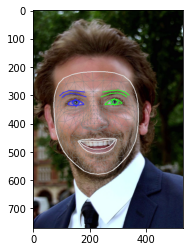

In [50]:
# source 얼굴 특징점 검출
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:

    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    # Print and draw face mesh landmarks on the image.
    annotated_image = image1.copy()
    for face_landmarks in results.multi_face_landmarks:
        landmarks_points = []
        for n in range(0, 468):
            x = face_landmarks.landmark[n].x
            y = face_landmarks.landmark[n].y
            landmarks_points.append((x,y))
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())
        plt.imshow(annotated_image)

        
        points = np.array(landmarks_points, np.int32)
        
        # 얼굴 특징점 경계선 추출
        convexhull = cv2.convexHull(points)
        cv2.fillConvexPoly(mask, convexhull, 255)
        
        
        # 얼굴 특징점 경계선을 따라 얼굴 이미지 추출
        face_image_1 = cv2.bitwise_and(img, img, mask=mask)

        # source 얼굴 들로네 삼각망 구축
        rect = cv2.boundingRect(convexhull)
        subdiv = cv2.Subdiv2D(rect)
        subdiv.insert(landmarks_points)
        triangles = subdiv.getTriangleList()
        triangles = np.array(triangles, dtype=np.int32)
        
        # 들로네 삼각망의 triangles 인덱스 구하기 
        indexes_triangles = []
        for t in triangles:
            pt1 = (t[0], t[1])
            pt2 = (t[2], t[3])
            pt3 = (t[4], t[5])
    
    
            index_pt1 = np.where((points == pt1).all(axis=1))
            index_pt1 = extract_index_nparray(index_pt1)
    
            index_pt2 = np.where((points == pt2).all(axis=1))
            index_pt2 = extract_index_nparray(index_pt2)
    
            index_pt3 = np.where((points == pt3).all(axis=1))
            index_pt3 = extract_index_nparray(index_pt3)
    
            if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
                triangle = [index_pt1, index_pt2, index_pt3]
                indexes_triangles.append(triangle)

In [ ]:

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image = image[:,:, ::-1]
    
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
      continue
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
      print('face_landmarks:', face_landmarks)
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_contours_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_iris_connections_style())
    plt.imshow(annotated_image)
#     cv2.imwrite('./result/annotated_image' + str(idx) + '.png', annotated_image)